In [1]:
import pandas as pd
import seaborn as sns
import datetime
import numpy as np

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
pd.set_option('display.max_columns', None)

In [2]:
covid_indicator = pd.read_csv('data/table-indicateurs-open-data-france-2022-08-05-19h01.csv')
covid_test = pd.read_csv('data/sp-fra-jour-2022-08-05-19h01.csv', sep=';')

In [3]:
covid_indicator

,date,tx_pos,tx_incid,TO,R,rea,hosp,rad,dchosp,incid_rea,incid_hosp,incid_rad,incid_dchosp,conf,conf_j1,pos,esms_dc,dc_tot,pos_7j,cv_dose1,esms_cas
0,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-08-01,22.71,421.17,0.238236,NaN,1205.0,20063.0,713025.0,123157.0,130.0,1195.0,1046.0,122.0,NaN,7249.0,56657.0,29022.0,152179.0,285823.0,NaN,402595.0
922,2022-08-02,22.21,392.00,0.233294,NaN,1180.0,19792.0,714464.0,123258.0,141.0,1306.0,1453.0,104.0,NaN,54519.0,36763.0,29022.0,152280.0,266022.0,NaN,402615.0
923,2022-08-03,NaN,NaN,0.227560,NaN,1151.0,19389.0,715761.0,123341.0,92.0,1001.0,1316.0,86.0,NaN,38788.0,NaN,29029.0,152370.0,NaN,NaN,403320.0
924,2022-08-04,NaN,NaN,0.227560,NaN,1151.0,19154.0,716889.0,123426.0,107.0,1002.0,1145.0,87.0,NaN,33799.0,NaN,29031.0,152457.0,NaN,80.3,403749.0


<AxesSubplot:ylabel='date'>

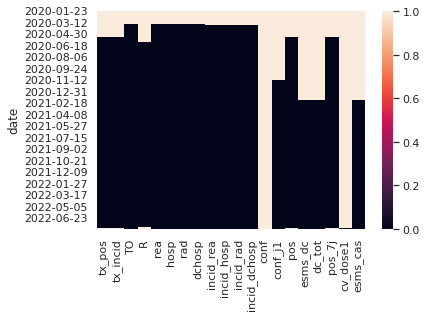

In [4]:
sns.heatmap(covid_indicator.set_index('date').isna())

In [7]:
features = ['hosp', 
        'incid_hosp', 
        'rea', 
        'incid_rea', 
        'rad', 
        'incid_rad',
        'pos',
        'pos_7j',
        'tx_pos',
        'tx_incid',
        'TO',
        'R']

target = ['incid_dchosp']

<AxesSubplot:ylabel='date'>

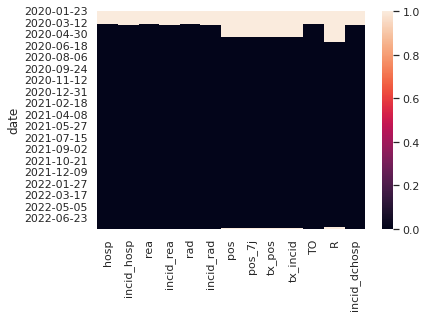

In [8]:
sns.heatmap(covid_indicator.set_index('date')[features + target].isna())

In [9]:
features += ['pop', 'P', 'T', 'Ti', 'Tp', 'Td']

In [10]:
covid_test.loc[:, ['pop', 'P', 'T', 'Ti', 'Tp', 'Td']] = covid_test.loc[:, ['pop', 'P', 'T', 'Ti', 'Tp', 'Td']].applymap(lambda row: float(row.replace(',','.')))

In [116]:
covid_df = pd.merge(
        left=covid_indicator,
        right=covid_test,
        left_on='date',
        right_on='jour',
        how='inner')

covid_df = covid_df[['date'] + features + target].dropna()



In [117]:
def get_j7_dc(row):
    try:
        j7_date = datetime.datetime.strftime(datetime.datetime.strptime(row['date'], '%Y-%m-%d') + datetime.timedelta(days=30), '%Y-%m-%d')
        j7_dc = covid_df.loc[covid_df.date == j7_date, 'incid_dchosp'].values[0]
        return(j7_dc)
    except:
        return(-1)
covid_df.loc[:, 'dc_j7'] = covid_df.apply(get_j7_dc, axis=1)

In [118]:
covid_df = covid_df.loc[covid_df.dc_j7 != -1, :]
covid_df.set_index('date', inplace=True)

In [119]:
df_train, df_val = covid_df.iloc[:-30], covid_df.iloc[-30:]

X_train, y_train = df_train[features], df_train['dc_j7']
X_val, y_val = df_val[features], df_val['dc_j7']


In [120]:
rf = RandomForestRegressor(random_state=0)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [121]:
y_pred = np.round(y_pred)

In [122]:
mae = mean_absolute_error(y_val, y_pred)
mae

33.4

In [123]:
y_pred

array([45., 41., 52., 63., 81., 79., 64., 66., 65., 65., 71., 82., 70.,
       68., 70., 71., 69., 76., 89., 70., 72., 68., 74., 72., 75., 85.,
       77., 73., 69., 74.])

In [124]:
y_val

date
2022-06-01     51.0
2022-06-02     30.0
2022-06-03     13.0
2022-06-04     97.0
2022-06-05     75.0
2022-06-06     48.0
2022-06-07     86.0
2022-06-08     74.0
2022-06-09     34.0
2022-06-10     15.0
2022-06-11    108.0
2022-06-12    123.0
2022-06-13    104.0
2022-06-14     49.0
2022-06-15    103.0
2022-06-16     60.0
2022-06-17     17.0
2022-06-18    174.0
2022-06-19    144.0
2022-06-20    108.0
2022-06-21    128.0
2022-06-22    104.0
2022-06-23     48.0
2022-06-24     19.0
2022-06-25    132.0
2022-06-26    119.0
2022-06-27     95.0
2022-06-28    104.0
2022-06-29     82.0
2022-06-30     52.0
Name: dc_j7, dtype: float64

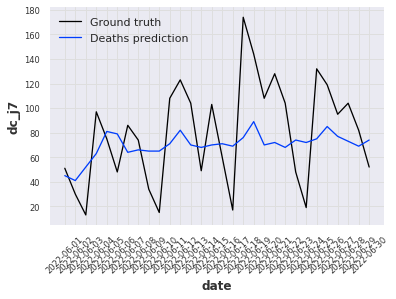

In [125]:
plt.xticks(rotation=45)
sns.lineplot(x=covid_df.index[-30:], y=y_val, label='Ground truth')
sns.lineplot(x=covid_df.index[-30:], y=y_pred, label='Deaths prediction')
plt.legend()

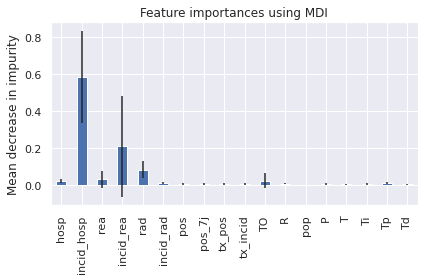

In [21]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=features)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [22]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.Series(result.importances_mean, index=features)

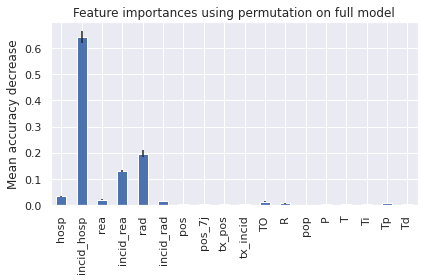

In [23]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# DARTS

In [88]:
from darts import TimeSeries
from darts.models import RegressionModel, RandomForest, ExponentialSmoothing, RNNModel, AutoARIMA
from sklearn.linear_model import LinearRegression


In [28]:
covid_df = covid_df.reset_index()

covid_df.loc[:, 'date'] = covid_df.date.apply(lambda row: datetime.datetime.strptime(row, '%Y-%m-%d'))
covid_df.set_index('date', inplace=True)

In [30]:
y = TimeSeries.from_series(covid_df[target])

In [43]:
future_cov = TimeSeries.from_dataframe(covid_df[features])

In [110]:
y_train = y[:-30]
y_val = y[-30:]

/home/wld/.local/share/virtualenvs/covid19-deaths-prediction-G3jfNdmc/lib/python3.9/site-packages/darts/timeseries.py:4039: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(


15.68533333333333

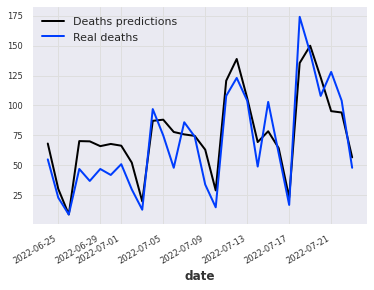

Epoch 41:  96%|█████████▌| 22/23 [00:15<00:00,  1.38it/s, loss=2.87e+04, train_loss=2.4e+4]


In [111]:
model = RegressionModel(
            lags=[-1, -2, -3, -4, -5, -6, -7],
            lags_future_covariates=[0],
            model=RandomForestRegressor()
)

model.fit(series=y_train, future_covariates=future_cov)
y_pred = model.predict(n=len(y_val), series=y_train, future_covariates=future_cov)

y_pred.plot(label='Deaths predictions')
y[-30:].plot(label='Real deaths')
mae = mean_absolute_error(y_val.values().reshape(-1), y_pred.values().reshape(-1))
mae


/home/wld/.local/share/virtualenvs/covid19-deaths-prediction-G3jfNdmc/lib/python3.9/site-packages/darts/timeseries.py:4039: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(


16.70133333333333

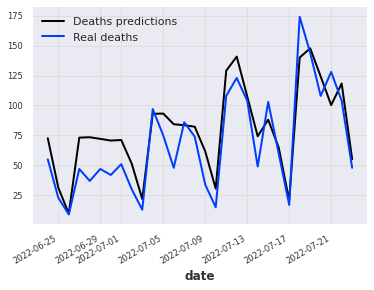

In [112]:
model = RandomForest(
            lags=[-1, -2, -3, -4, -5, -6, -7],
            lags_future_covariates=[0],
)

model.fit(series=y_train, future_covariates=future_cov)
y_pred = model.predict(n=len(y_val), series=y_train, future_covariates=future_cov)

y_pred.plot(label='Deaths predictions')
y[-30:].plot(label='Real deaths')
mae = mean_absolute_error(y_val.values().reshape(-1), y_pred.values().reshape(-1))
mae

38.47138726804272

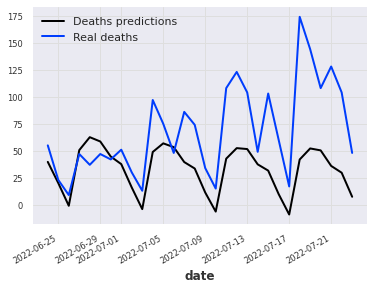

In [113]:
model = ExponentialSmoothing()
model.fit(y_train)
y_pred = model.predict(len(y_val), 1000).mean()

y_pred.plot(label='Deaths predictions')
y[-30:].plot(label='Real deaths')
mae = mean_absolute_error(y_val.values().reshape(-1), y_pred.values().reshape(-1))
mae

In [114]:
model = RNNModel(input_chunk_length=15)

model.fit(y_train)#, val_series=y_val, verbose=True)

y_pred = model.predict(len(y_val))

2022-08-08 22:28:47 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 729 samples.
2022-08-08 22:28:47 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-08-08 22:28:47 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-08-08 22:28:47 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-08-08 22:28:47 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-08-08 22:28:47 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-08-08 22:28:47 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 

Epoch 99: 100%|██████████| 23/23 [00:00<00:00, 41.07it/s, loss=2.23e+04, train_loss=1e+4]   

2022-08-08 22:29:46 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.20it/s]


34.82147750089039

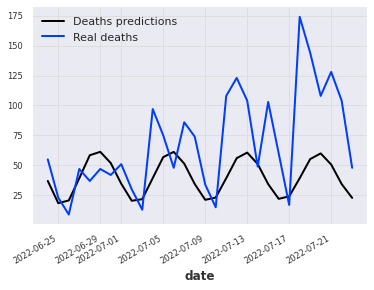

In [115]:
model_aarima = AutoARIMA()
model_aarima.fit(y_train)
y_pred = model_aarima.predict(len(y_val))

y_pred.plot(label='Deaths predictions')
y[-30:].plot(label='Real deaths')
mae = mean_absolute_error(y_val.values().reshape(-1), y_pred.values().reshape(-1))
mae